In [1]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import scipy

In [2]:
class Body:
    def __init__(self, location, mass, velocity, name):
        self.location = location
        self.mass = mass
        self.velocity = velocity
        self.name = name

In [3]:
def Hamiltonian(bodies):
    G_const = 6.67408e-11
    H = 0
    
    for i in range(len(bodies)):
        H = H + 0.5 * bodies[i].mass * np.sum(np.square(bodies[i].velocity))
        for j in range(i + 1, len(bodies)):
            H = H - G_const * bodies[i].mass * bodies[j].mass / np.sqrt(np.sum(np.square(bodies[i].location - bodies[j].location)))
    
    return H

In [4]:
class Integrator():
    def __init__(self, time_step, bodies):
        self.time_step = time_step
        self.bodies = bodies
        self.Hamiltonian = Hamiltonian(bodies)
        
    def compute_velocity(self):
        for body_index, target_body in enumerate(self.bodies):
            acceleration = self.calculate_single_body_acceleration(body_index)
            target_body.velocity += acceleration * self.time_step
    
    def update_location(self):
        for target_body in self.bodies:
            target_body.location += target_body.velocity * self.time_step
        
    def update_Hamiltonian(self):
        self.Hamiltonian = Hamiltonian(self.bodies)
        
    def compute_gravity_step(self):
        self.compute_velocity()
        self.update_location()
        self.update_Hamiltonian()

In [5]:
class Euler(Integrator):
    def __init__(self, time_step, bodies):
        super().__init__(time_step, bodies)
    
    def calculate_single_body_acceleration(self, body_index):
        G_const = 6.67408e-11
        acceleration = np.array([0, 0, 0], dtype = np.float64)
        target_body = self.bodies[body_index]
        for index, external_body in enumerate(bodies):
            if index != body_index:
                r = np.sum(np.square(target_body.location - external_body.location))
                r = math.sqrt(r)
                tmp = G_const * external_body.mass / r**3
                acceleration += tmp * (external_body.location - target_body.location)
    
        return acceleration

In [6]:
class RK4(Integrator):
    def __init__(self, time_step, bodies):
        super().__init__(time_step, bodies)
    
    def calculate_single_body_acceleration(self, body_index):
        G_const = 6.67408e-11
        acceleration = np.array([0, 0, 0], dtype = np.float64)
        target_body = self.bodies[body_index]

        k1 = np.array([0, 0, 0], dtype = np.float64)
        k2 = np.array([0, 0, 0], dtype = np.float64)
        k3 = np.array([0, 0, 0], dtype = np.float64)
        k4 = np.array([0, 0, 0], dtype = np.float64)
        tmp_loc = np.array([0, 0, 0], dtype = np.float64)
        tmp_vel = np.array([0, 0, 0], dtype = np.float64)

        for index, external_body in enumerate(self.bodies):
            if index != body_index:
                r = np.sum(np.square(target_body.location - external_body.location))
                r = math.sqrt(r)
                tmp = G_const * external_body.mass / r**3

                #k1 - regular Euler acceleration
                k1 = tmp * (external_body.location - target_body.location)

                #k2 - acceleration 0.5 timesteps in the future based on k1 acceleration value
                tmp_vel = target_body.velocity + k1 * 0.5
                tmp_loc = target_body.location + tmp_vel * 0.5 * self.time_step
                k2 = (external_body.location - tmp_loc) * tmp

                #k3 acceleration 0.5 timesteps in the future using k2 acceleration
                tmp_vel = target_body.velocity + k2 * 0.5
                tmp_loc = target_body.location + tmp_vel * 0.5 * self.time_step
                k3 = (external_body.location - tmp_loc) * tmp

                #k4 - location 1 timestep in the future using k3 acceleration
                tmp_vel = target_body.velocity + k3 * 1
                tmp_loc = target_body.location + tmp_vel * self.time_step
                k4 = (external_body.location - tmp_loc) * tmp

                acceleration += (k1 + k2 * 2 + k3 * 2 + k4) / 6

        return acceleration

In [7]:
class Verlet():
    def __init__(self, time_step, bodies):
        self.time_step = time_step
        self.bodies = bodies
        self.Hamiltonian = Hamiltonian(bodies)
        # self.prev_acc = np.array([0, 0, 0], dtype = np.float64)
    
    def calculate_single_body_acceleration(self, body_index):
        G_const = 6.67408e-11
        acceleration = np.array([0, 0, 0], dtype = np.float64)
        target_body = self.bodies[body_index]
        for index, external_body in enumerate(bodies):
            if index != body_index:
                r = np.sum(np.square(target_body.location - external_body.location))
                r = math.sqrt(r)
                tmp = G_const * external_body.mass / r**3
                acceleration += tmp * (external_body.location - target_body.location)

        return acceleration
        
    def compute_velocity(self):
        for body_index, target_body in enumerate(self.bodies):
            acceleration = self.calculate_single_body_acceleration(body_index)
            target_body.velocity += acceleration * self.time_step
    
    def update_location(self):
        for target_body in self.bodies:
            target_body.location += target_body.velocity * self.time_step
        
    def update_Hamiltonian(self):
        self.Hamiltonian = Hamiltonian(self.bodies)
        
    def compute_gravity_step(self):
        self.compute_velocity()
        self.update_location()
        self.update_Hamiltonian()

In [8]:
def plot_output(bodies, outfile = None):
    lnames = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto", "Satellite"]
    
    if (len(bodies) == 2 and bodies[0]["name"] == "Sun" and bodies[1]["name"] == "Earth"):
        figure, axes = plt.subplots(1)
        draw_circle = plt.Circle((0, 0), 1.5e11, fill = False)
        axes.set_aspect(1)
        plt.xlim(-2e11, 2e11)
        plt.ylim(-2e11, 2e11)
        axes.add_artist(draw_circle)
        e = axes.scatter(bodies[1]["x"], bodies[1]["y"], s = 1)
        s = axes.scatter([0], [0])
        plt.legend((e, s),
           ("Earth", "Sun"))
        plt.show()
    else:
        figure, axes = plt.subplots(1)
        axes.set_aspect(1)
        colours = ['r', 'b', 'g', 'y', 'm', 'c']
        max_range = 0
        for current_body in bodies: 
            max_dim = max(max(current_body["x"]),max(current_body["y"]),-min(current_body["x"]),-min(current_body["y"]))
            if max_dim > max_range:
                max_range = max_dim
            axes.scatter(current_body["x"], current_body["y"], c = random.choice(colours), label = current_body["name"], s = 1)        

        axes.set_xlim([-max_range * 1.1, max_range * 1.1])    
        axes.set_ylim([-max_range * 1.1, max_range * 1.1])
        axes.legend()        

        if outfile:
            plt.savefig(outfile)
        else:
            plt.show()
    
def plot_error(bodies, outfile = None):
    figure, axes = plt.subplots(1)
    axes.scatter(bodies["t"], bodies["H"], s = 1)
    plt.show()

def run_simulation(integrator, initial_H, names = None, time_step = 10000, number_of_steps = 10000, report_freq = 100):
    body_locations_hist = []
    H_history = {"t": [], "H": []}
    for current_body in bodies:
        body_locations_hist.append({"x": [], "y": [], "z": [], "name": current_body.name})
        
    for i in range(0, int(number_of_steps)):
        integrator.compute_gravity_step()
        
        H_history["t"].append(i * time_step)
        H_history["H"].append(np.log(np.abs((integrator.Hamiltonian - initial_H)/initial_H)))
        
        if i % report_freq == 0:
            for index, body_location in enumerate(body_locations_hist):
                body_location["x"].append(bodies[index].location[0])
                body_location["y"].append(bodies[index].location[1])           
                # body_location["z"].append(bodies[index].location[2])

    return (body_locations_hist, H_history)

In [40]:
#planet data (location (m), mass (kg), velocity (m/s)
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Mercury = {"location": np.array([0,5.0e10,0], dtype = np.float64), "mass": 3.285e23, "velocity": np.array([47000,0,0], dtype = np.float64)}
Venus = {"location": np.array([0,1.1e11,0], dtype = np.float64), "mass": 4.8e24, "velocity": np.array([35000,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}
Mars = {"location": np.array([0,2.2e11,0], dtype = np.float64), "mass": 6.4e23, "velocity": np.array([24000,0,0], dtype = np.float64)}
Jupiter = {"location": np.array([0,7.7e11,0], dtype = np.float64), "mass": 1e28, "velocity": np.array([13000,0,0], dtype = np.float64)}
Saturn = {"location": np.array([0,1.4e12,0], dtype = np.float64), "mass": 5.7e26, "velocity": np.array([9000,0,0], dtype = np.float64)}
Uranus = {"location": np.array([0,2.8e12,0], dtype = np.float64), "mass": 8.7e25, "velocity": np.array([6835,0,0], dtype = np.float64)}
Neptune = {"location": np.array([0,4.5e12,0], dtype = np.float64), "mass": 1e26, "velocity": np.array([5477,0,0], dtype = np.float64)}
Pluto = {"location": np.array([0,3.7e12,0], dtype = np.float64), "mass": 1.3e22, "velocity": np.array([4748,0,0], dtype = np.float64)}
Satellite = {"location": np.array([0,1.0e10,0], dtype = np.float64), "mass": 1e23, "velocity": np.array([3e4,0,0], dtype = np.float64)}

In [41]:
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 31557600
time_step = 1e1
number_of_steps = int(period/time_step)

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

KeyboardInterrupt: 

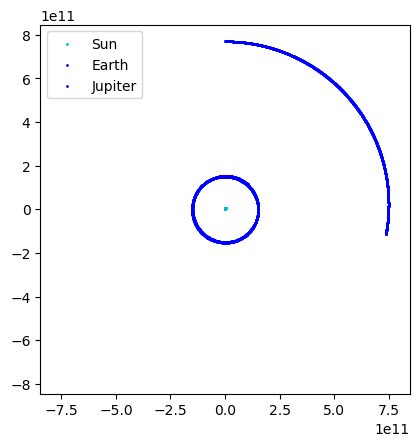

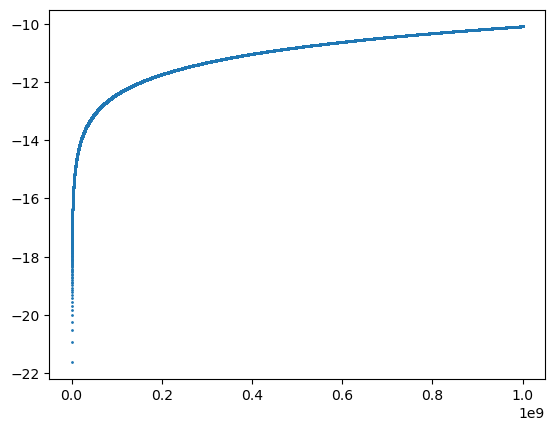

In [31]:
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}
Jupiter = {"location": np.array([0,7.7e11,0], dtype = np.float64), "mass": 1e28, "velocity": np.array([13000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    Body (location = Jupiter["location"], mass = Jupiter["mass"], velocity = Jupiter["velocity"], name = "Jupiter"),
    ]

period = 0
time_step = 1e3
number_of_steps = 1e5

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

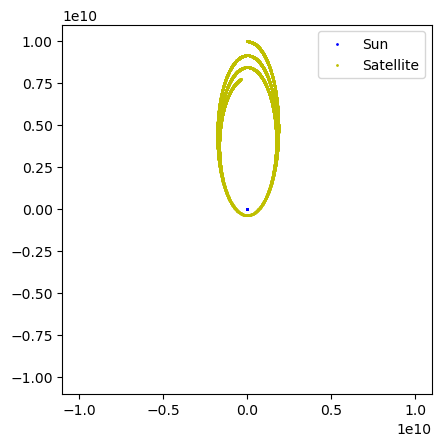

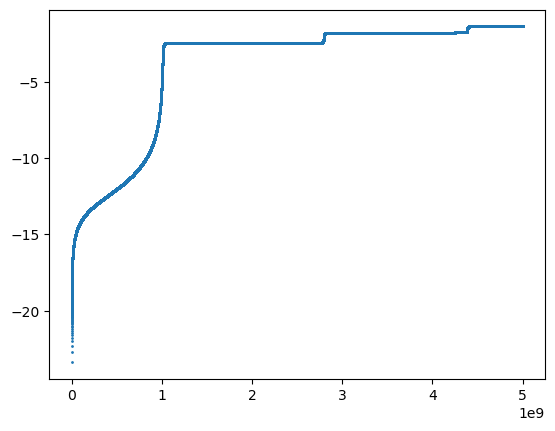

In [22]:
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Satellite = {"location": np.array([0,1.0e10,0], dtype = np.float64), "mass": 1e23, "velocity": np.array([3e4,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Satellite["location"], mass = Satellite["mass"], velocity = Satellite["velocity"], name = "Satellite"),
    ]

period = 0
time_step = 1
number_of_steps = 5e5

initial_H = Hamiltonian(bodies)
# integrator = Euler(time_step = 10, bodies = bodies) # satellite
integrator = RK4(time_step = time_step, bodies = bodies)
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2) #5e6
plot_output(motions)
plot_error(error)

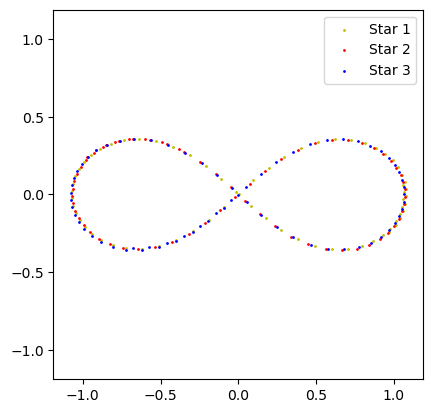

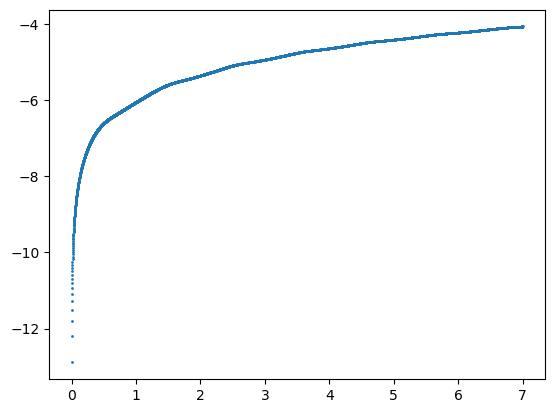

In [60]:
x1 = {"location": np.array([0.97000435669734,-0.24308753153583,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([0.93240737144104/2,0.86473146092102/2,0], dtype = np.float64)}
x2 = {"location": np.array([-0.97000435669734,0.24308753153583,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([0.93240737144104/2,0.86473146092102/2,0], dtype = np.float64)}
x3 = {"location": np.array([0,0,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([-0.93240737144104,-0.86473146092102,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.001
number_of_steps = 7000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0001 100000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

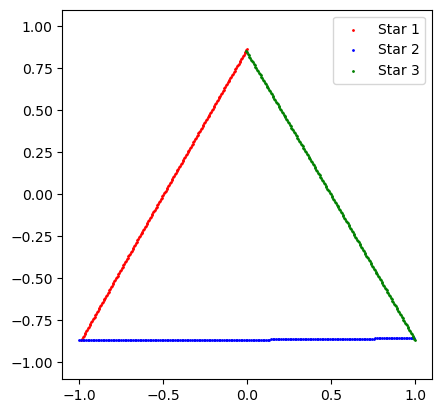

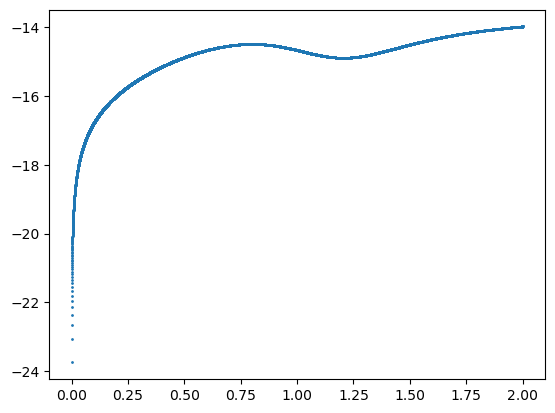

In [59]:
x1 = {"location": np.array([0,np.sqrt(3)/2,0], dtype = np.float64), "mass": 1e8, "velocity": np.array([-math.sin(math.radians(30)),-math.cos(math.radians(30)),0], dtype = np.float64)}
x2 = {"location": np.array([-1,-np.sqrt(3)/2,0], dtype = np.float64), "mass": 1e8, "velocity": np.array([1,0,0], dtype = np.float64)}
x3 = {"location": np.array([1,-np.sqrt(3)/2,0], dtype = np.float64), "mass": 1e8, "velocity": np.array([-math.sin(math.radians(30)),math.cos(math.radians(30)),0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 20000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies)
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

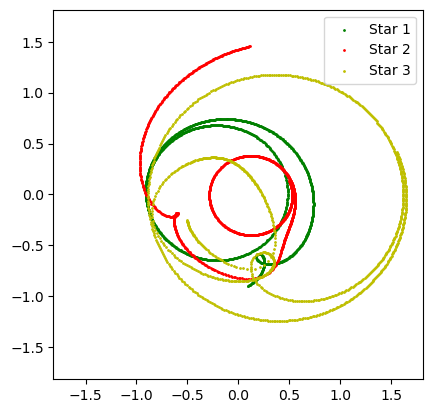

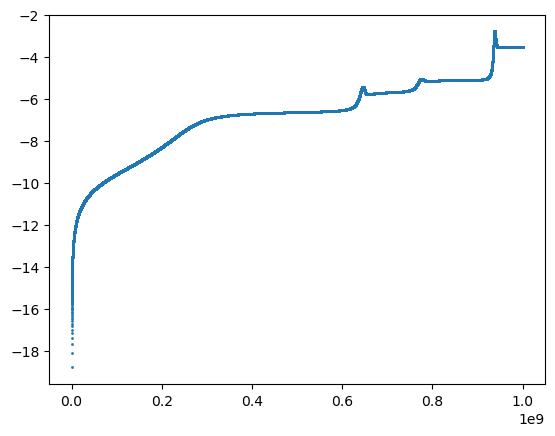

In [25]:
x1 = {"location": np.array([-0.8520980041,-0.2283189721,0], dtype = np.float64), "mass": 3e10, "velocity": np.array([-0.2792477603,0.6557964988, 0], dtype = np.float64)}
x2 = {"location": np.array([0.5001981527,0.1340276911,0], dtype = np.float64), "mass": 2e10, "velocity": np.array([0.1639238834,-0.3849653392, 0], dtype = np.float64)}
x3 = {"location": np.array([1.5558977071,0.4169015341,0], dtype = np.float64), "mass": 1e10, "velocity": np.array([0.5098955142,-1.1974588179,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 100000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

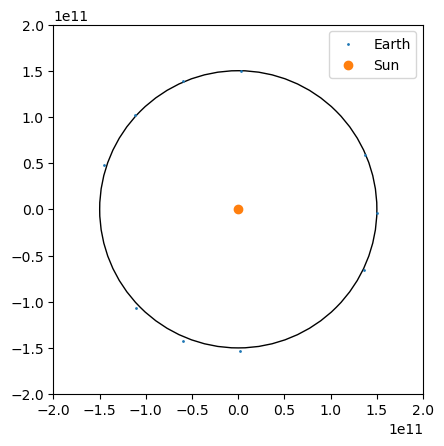

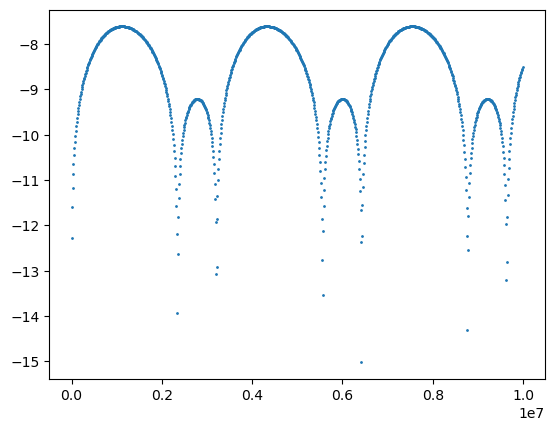

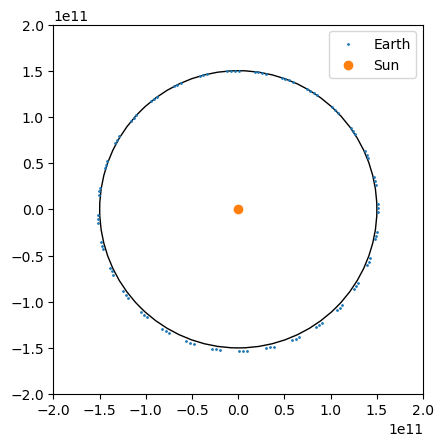

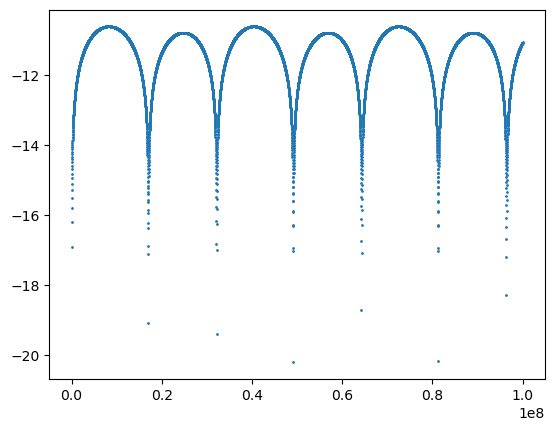

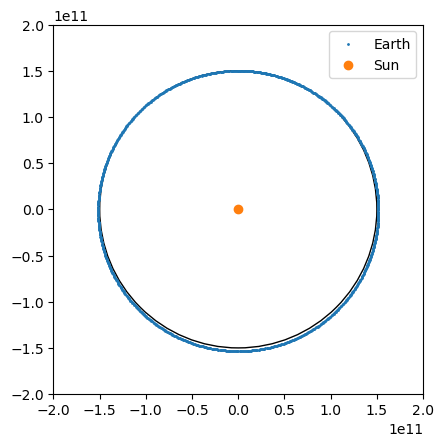

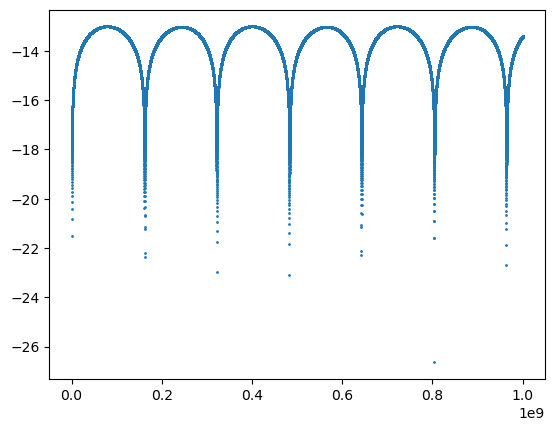

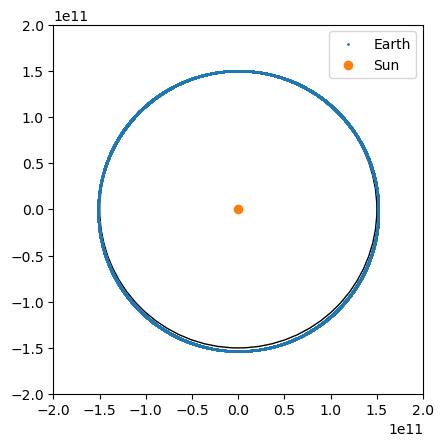

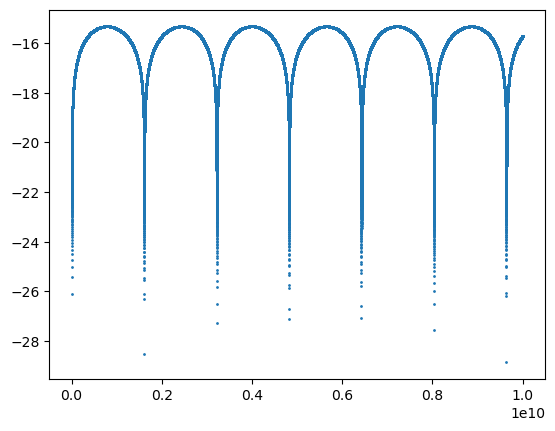

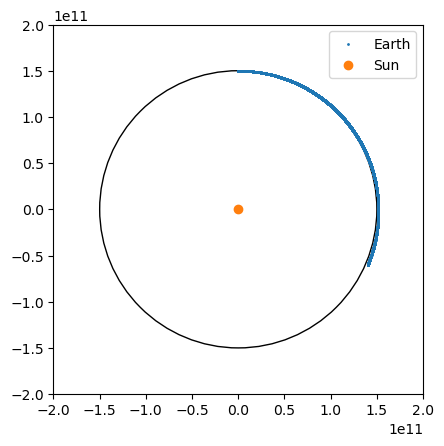

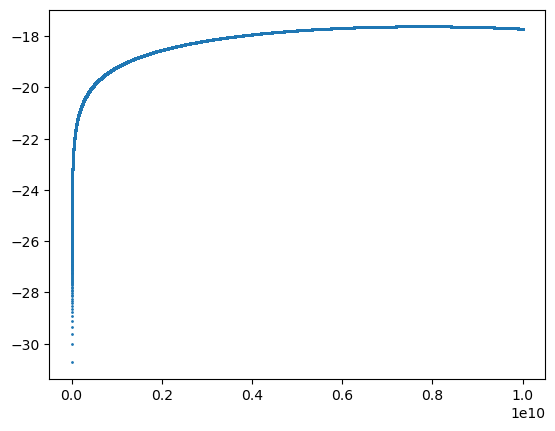

In [26]:
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 0
time_step = 1e5
number_of_steps = 1e3

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = 1e5, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 0
time_step = 1e4
number_of_steps = 1e4

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = 1e4, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 0
time_step = 1e3
number_of_steps = 1e5

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = 1e3, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 0
time_step = 1e2
number_of_steps = 1e6

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = 1e2, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30000,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 31557600
time_step = 1e1
number_of_steps = int(period/time_step)

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = 1e1, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

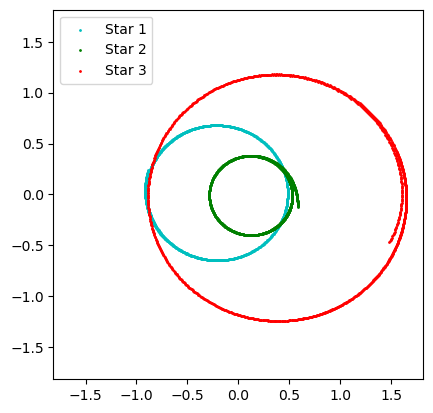

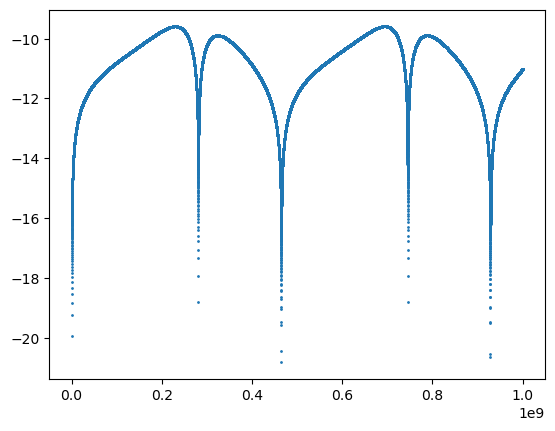

In [27]:
x1 = {"location": np.array([-0.8520980041,-0.2283189721,0], dtype = np.float64), "mass": 3e10, "velocity": np.array([-0.2792477603,0.6557964988, 0], dtype = np.float64)}
x2 = {"location": np.array([0.5001981527,0.1340276911,0], dtype = np.float64), "mass": 2e10, "velocity": np.array([0.1639238834,-0.3849653392, 0], dtype = np.float64)}
x3 = {"location": np.array([1.5558977071,0.4169015341,0], dtype = np.float64), "mass": 1e10, "velocity": np.array([0.5098955142,-1.1974588179,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 100000

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

<AxesSubplot:>

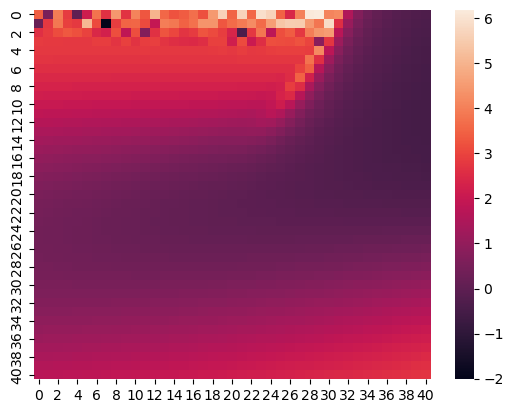

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

hml = []
jump = 10
count = 0

for i in range(-200, 201, jump):
    for j in range(-200, 201, jump):
        
        x1 = {"location": np.array([0.97000435669734,-0.24308753153583,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([0.93240737144104/2,0.86473146092102/2,0], dtype = np.float64)}
        x2 = {"location": np.array([-0.97000435669734,0.24308753153583,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([0.93240737144104/2,0.86473146092102/2,0], dtype = np.float64)}
        x3 = {"location": np.array([0,0,0], dtype = np.float64), "mass": 1.5e10, "velocity": np.array([-0.93240737144104,-0.86473146092102,0], dtype = np.float64)}
        
        bodies = [
            Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"] + np.array([j/1000, i/1000, 0], dtype = np.float64), name = "Star 1"),
            Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
            Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
            ]

        period = 0
        time_step = 0.005
        number_of_steps = 700

        initial_H = Hamiltonian(bodies)
        integrator = RK4(time_step = time_step, bodies = bodies) #0.0001 100000
        (motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
        
        hml.append(error["H"][-1])
        
        count = count + 1
        print('iteration {}'.format(count))

print(hml)
hm = np.array(hml).reshape((int(np.sqrt(len(hml))), int(np.sqrt(len(hml))))) - hml[int(len(hml)/2)]
sns.heatmap(hm)

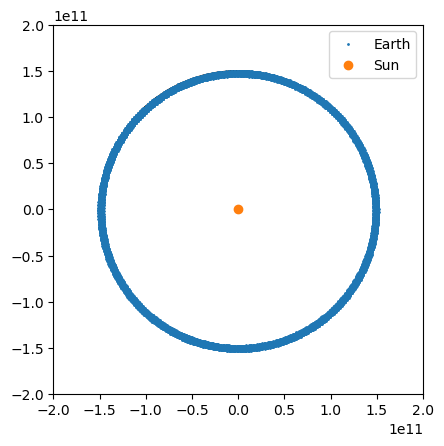

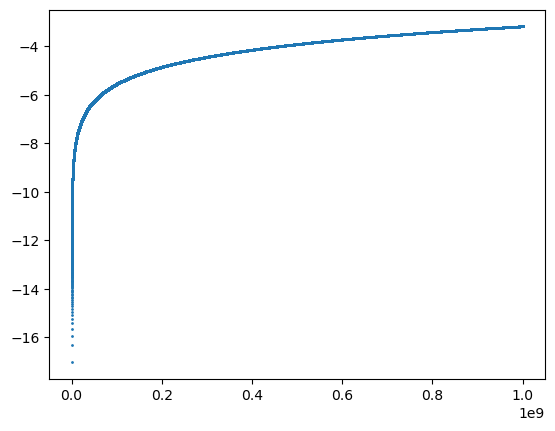

In [28]:
Sun = {"location": np.array([0,0,0], dtype = np.float64), "mass": 2e30, "velocity": np.array([0,0,0], dtype = np.float64)}
Earth = {"location": np.array([0,1.5e11,0], dtype = np.float64), "mass": 6e24, "velocity": np.array([30010,0,0], dtype = np.float64)}

bodies = [
    Body(location = Sun["location"], mass = Sun["mass"], velocity = Sun["velocity"], name = "Sun"),
    Body(location = Earth["location"], mass = Earth["mass"], velocity = Earth["velocity"], name = "Earth"),
    ]

period = 0
time_step = 1e3
number_of_steps = 1e6 #3e4

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) # Sun Earth Jupiter
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

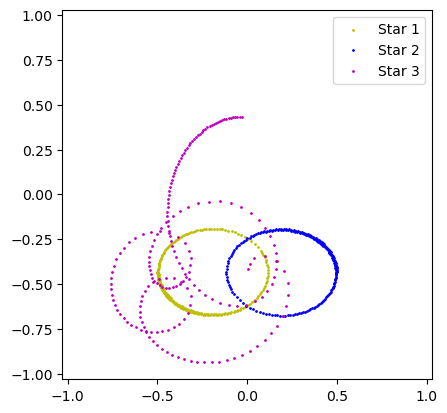

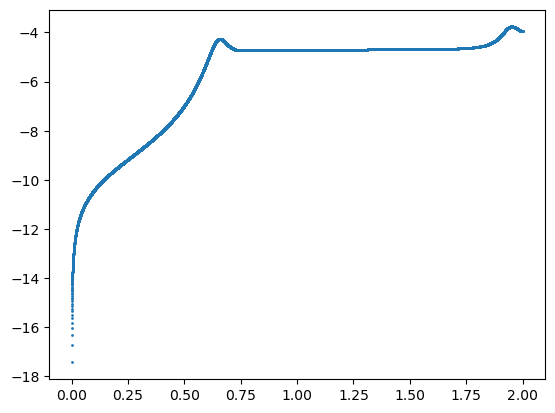

In [147]:
x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
x3 = {"location": np.array([-0.03,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 20000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

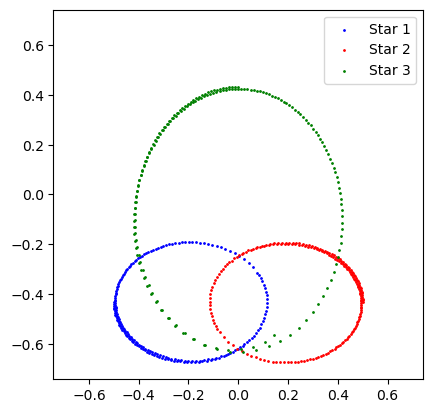

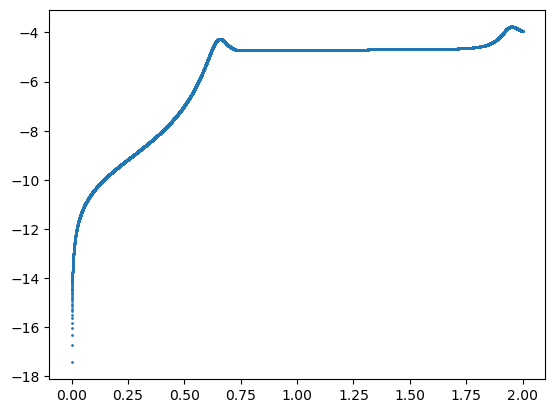

In [9]:
x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 20000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

In [10]:
# x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
# x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
# x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

# bodies = [
#     Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
#     Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
#     Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
#     ]

# period = 0
# time_step = 0.0001
# number_of_steps = 20000

# initial_H = Hamiltonian(bodies)
# integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
# (motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

<AxesSubplot:>

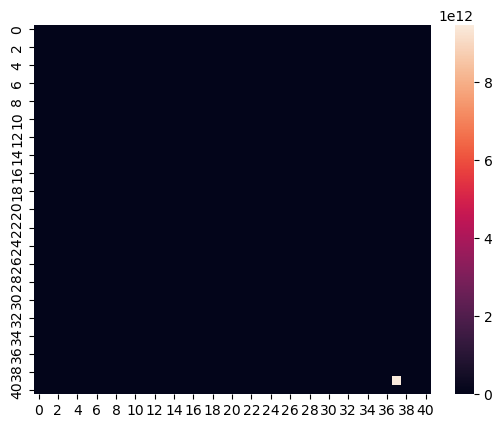

In [11]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# hml = []
# jump = 10
# count = 0

# x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
# x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
# x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

# bodies = [
#     Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
#     Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
#     Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
#     ]

# period = 0
# time_step = 0.01
# number_of_steps = 2000

# initial_H = Hamiltonian(bodies)
# integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
# (cmotions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)

# for i in range(-200, 201, jump):
#     for j in range(-200, 201, jump):
        
#         s = 0
        
#         x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
#         x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
#         x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2) + i/100, 0 + j/100, 0], dtype = np.float64)}

#         bodies = [
#             Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
#             Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
#             Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
#             ]

#         period = 0
#         time_step = 0.01
#         number_of_steps = 2000

#         initial_H = Hamiltonian(bodies)
#         integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
#         (motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
        
#         for body in range(len(np.array(motions))):
#             s += np.sqrt(np.sum(np.square(np.array(cmotions[body]["x"]) - np.array(motions[body]["x"]))))
#             s += np.sqrt(np.sum(np.square(np.array(cmotions[body]["y"]) - np.array(motions[body]["y"]))))
        
#         hml.append(s)
        
#         count = count + 1
#         print('iteration {}'.format(count))

# print(hml)
# hm = np.array(hml).reshape((int(np.sqrt(len(hml))), int(np.sqrt(len(hml)))))
# sns.heatmap(hm)

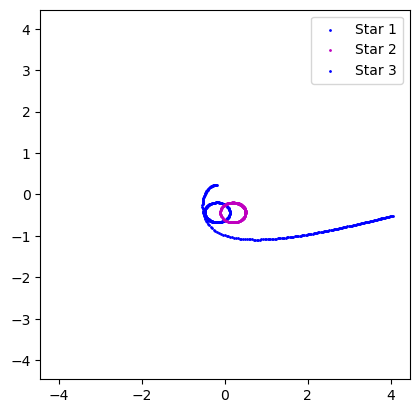

In [24]:
# x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
# x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
# x3 = {"location": np.array([-0.2,np.sqrt(3)/4-0.2,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

# bodies = [
#     Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
#     Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
#     Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
#     ]

# period = 0
# time_step = 0.0001
# number_of_steps = 20000

# initial_H = Hamiltonian(bodies)
# integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
# (cmotions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
# plot_output(cmotions)

200 20
200 20
200 20
iteration 2000, 100000
200 20
200 20
200 20
iteration 2000, 10000
200 20
200 20
200 20
iteration 2000, 1000
200 20
200 20
200 20
iteration 2000, 100
200 20
200 20
200 20
iteration 2000, 10
200 20
200 20
200 20
iteration 2000, 1
200 20
200 20
200 20
iteration 2000, 0.1
200 20
200 20
200 20
iteration 2000, 0.01
200 20
200 20
200 20
iteration 2000, 0.001
200 20
200 20
200 20
iteration 2000, 0.0001
200 20
200 20
200 20
iteration 2000, 1e-05
200 20
200 20
200 20
iteration 2000, 1e-06
200 200
200 200
200 200
iteration 20000, 100000
200 200
200 200
200 200
iteration 20000, 10000
200 200
200 200
200 200
iteration 20000, 1000
200 200
200 200
200 200
iteration 20000, 100
200 200
200 200
200 200
iteration 20000, 10
200 200
200 200
200 200
iteration 20000, 1
200 200
200 200
200 200
iteration 20000, 0.1
200 200
200 200
200 200
iteration 20000, 0.01
200 200
200 200
200 200
iteration 20000, 0.001
200 200
200 200
200 200
iteration 20000, 0.0001
200 200
200 200
200 200
iteration 20

<AxesSubplot:>

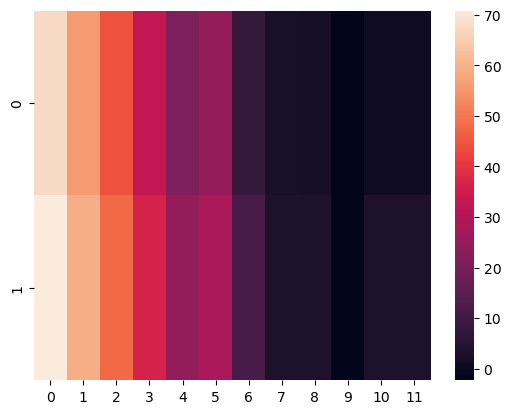

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

hml = []
dtl = [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001 , 0.0001, 0.00001, 0.000001]
nsl = [2000, 20000]

x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.0001
number_of_steps = 20000
report_freq = 1e2

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
(cmotions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)

for i in nsl:
    
#     x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
#     x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
#     x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

#     bodies = [
#         Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
#         Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
#         Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
#         ]

#     period = 0
#     time_step = 0.0001
#     number_of_steps = i

#     initial_H = Hamiltonian(bodies)
#     integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
#     (cmotions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
    
    for j in dtl:
        
        s = 0
        
        x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
        x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
        x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0, 0], dtype = np.float64)}

        bodies = [
            Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
            Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
            Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
            ]

        period = 0
        time_step = j
        number_of_steps = i

        initial_H = Hamiltonian(bodies)
        integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
        (motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
        
        for body in range(len(np.array(motions))):
            # print(len(cmotions[body]["x"]), len(motions[body]["x"]))
            s += np.sqrt(np.sum(np.square(np.array(cmotions[body]["x"])[0:int(i/report_freq)] - np.array(motions[body]["x"]))))
            s += np.sqrt(np.sum(np.square(np.array(cmotions[body]["y"])[0:int(i/report_freq)] - np.array(motions[body]["y"]))))
        
        hml.append(s)
        
        print('iteration {}, {}'.format(i, j))

print(hml)
hm = np.array(hml).reshape((len(nsl), len(dtl)))
hm[hm == 0] = 0.1
sns.heatmap(np.log(hm))

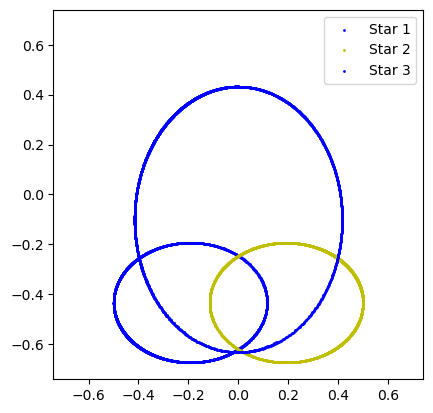

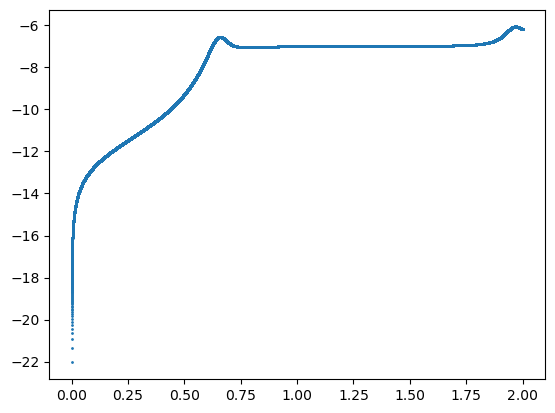

In [43]:
x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.00001
number_of_steps = 200000

initial_H = Hamiltonian(bodies)
integrator = RK4(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)

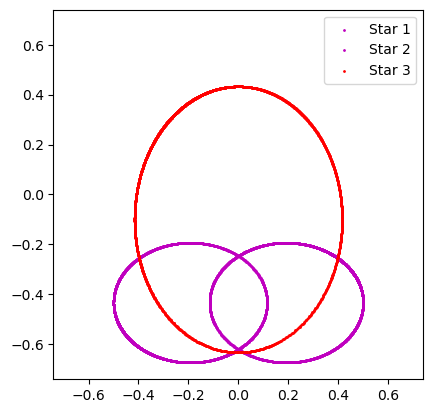

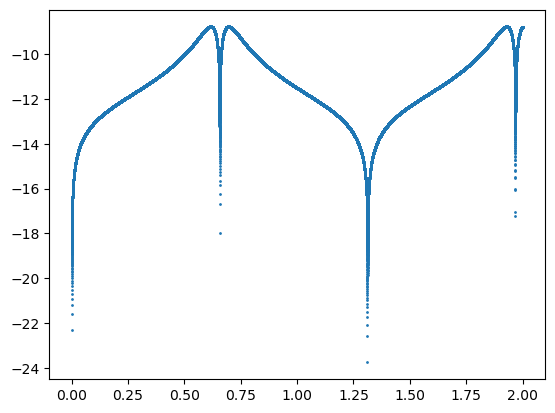

In [44]:
x1 = {"location": np.array([-1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, -1/np.sqrt(2), 0], dtype = np.float64)}
x2 = {"location": np.array([1/2,-np.sqrt(3)/4,0], dtype = np.float64), "mass": 4e10, "velocity": np.array([0, 1/np.sqrt(2), 0], dtype = np.float64)}
x3 = {"location": np.array([0,np.sqrt(3)/4,0], dtype = np.float64), "mass": 1e6, "velocity": np.array([-np.sqrt(3/2), 0,0], dtype = np.float64)}

bodies = [
    Body(location = x1["location"], mass = x1["mass"], velocity = x1["velocity"], name = "Star 1"),
    Body(location = x2["location"], mass = x2["mass"], velocity = x2["velocity"], name = "Star 2"),
    Body(location = x3["location"], mass = x3["mass"], velocity = x3["velocity"], name = "Star 3"),
    ]

period = 0
time_step = 0.00001
number_of_steps = 200000

initial_H = Hamiltonian(bodies)
integrator = Euler(time_step = time_step, bodies = bodies) #0.0005 50000
(motions, error) = run_simulation(integrator, initial_H, time_step = time_step, number_of_steps = number_of_steps, report_freq = 1e2)
plot_output(motions)
plot_error(error)